# The Configuration Model: Null Models for Network Analysis

## Introduction

When analyzing complex networks, a critical question is: *Which properties of the network are significant and which might occur by random chance?*

The **configuration model** provides a principled way to answer this question by generating random networks that preserve specific structural properties of the original network (typically the degree distribution) while randomizing other aspects.

### Why Use Null Models?

Null models help us:
- Identify which network features arise from specific degree distributions versus other organizational principles
- Test hypotheses about network formation mechanisms
- Establish baselines for comparing observed network properties

In this tutorial, we'll examine how the configuration model works and use it to analyze a real-world network.

In [17]:
# Import required libraries
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

## 1. Exploring the Real-World Network

We'll use the 'Les Misérables' character co-occurrence network - a well-known dataset that represents characters from Victor Hugo's novel and their co-appearances in chapters.

Each node represents a character, and edges connect characters who appear in the same chapter.

In [18]:
# Load the Les Misérables character co-occurrence network
G_real = nx.les_miserables_graph()

# Examine basic network properties
print(f"Number of nodes: {G_real.number_of_nodes()}")
print(f"Number of edges: {G_real.number_of_edges()}")
print(f"Average degree: {np.mean([d for _, d in G_real.degree()]):.2f}")

# Calculate clustering coefficient
real_clustering = nx.average_clustering(G_real)
print(f"Clustering coefficient: {real_clustering:.4f}")

# Calculate average shortest path length
real_path_length = nx.average_shortest_path_length(G_real)
print(f"Average shortest path length: {real_path_length:.4f}")

Number of nodes: 77
Number of edges: 254
Average degree: 6.60
Clustering coefficient: 0.5731
Average shortest path length: 2.6411


### Network Visualization

Let's visualize the original network to get an intuitive sense of its structure. Notice how characters cluster together based on their relationships in the novel's storyline.

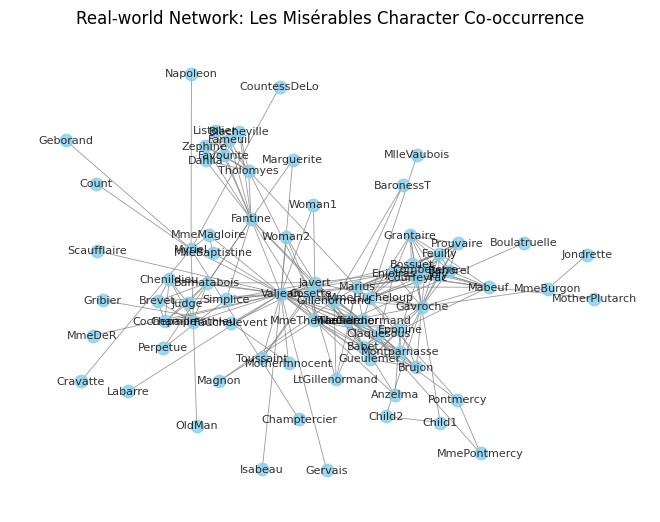

In [19]:
# Visualize the real network with smaller node labels and increased spacing between nodes
plt.figure()

pos = nx.spring_layout(G_real, seed=42, k=0.5)
nx.draw(G_real, pos, node_color='skyblue', edge_color='gray', 
        with_labels=True, node_size=80, width=0.6, alpha=0.8, font_size=8)
plt.title("Real-world Network: Les Misérables Character Co-occurrence")
plt.show()

## 2. The Configuration Model

The configuration model generates random networks while preserving each node's degree from the original network. This means each node will have the same number of connections as in the original network, but the specific connections will be randomized.

### How it works:

1. Extract the degree sequence from the original network
2. Give each node a number of "stubs" (half-edges) equal to its degree
3. Randomly pair these stubs to form edges

This process creates a random network that maintains the original degree distribution but randomizes the specific connections.

In [ ]:
# Extract the degree sequence from the real network
degree_sequence = [d for _, d in G_real.degree()]

# Create a randomized graph with the same degree distribution
# Set the seed for reproducibility
G_random = nx.configuration_model(degree_sequence, seed=42)

# Convert to simple graph (remove multi-edges)
G_random = nx.Graph(G_random)  # Remove multi-edges
# G_random.remove_edges_from(nx.selfloop_edges(G_random))  # Remove self-loops

Let's visualize our randomized network to see how it differs from the original:

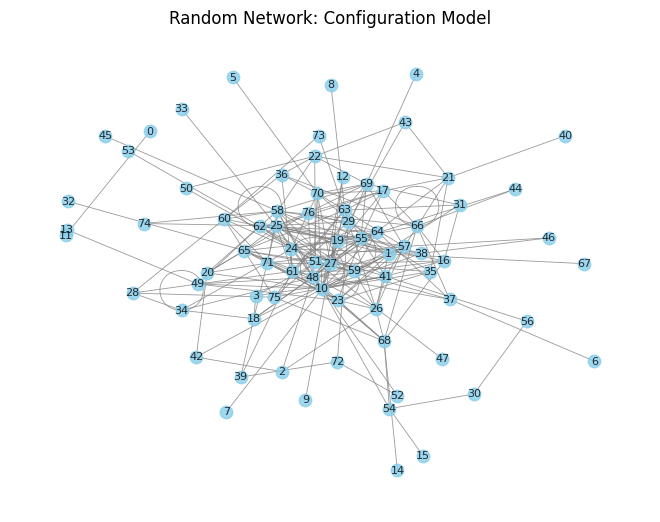

In [21]:
# Visualize the configuration model network with smaller node labels and increased spacing
plt.figure()
pos_random = nx.spring_layout(G_random, seed=42, k=0.5)
nx.draw(G_random, pos_random, node_color='skyblue', edge_color='gray', 
        with_labels=True, node_size=80, width=0.6, alpha=0.8, font_size=8)
plt.title("Random Network: Configuration Model")
plt.show()

## 3. Basic Network Property Comparison

Now let's compare some key properties between the original network and our randomized version. 
The most interesting comparison is often the **clustering coefficient**, which measures the tendency of nodes to form triangles (indicating "friends of friends are also friends").

If the real network has significantly higher clustering than the randomized version, this suggests that the clustering is not just a byproduct of the degree distribution but represents actual organization principles in the network.

In [26]:
# Calculate clustering coefficient for the randomized network
random_clustering = nx.average_clustering(G_random)

# Calculate average shortest path length for the randomized network
# First check if the network is connected to avoid errors
if nx.is_connected(G_random):
    random_path_length = nx.average_shortest_path_length(G_random)
else:
    # Find largest connected component and calculate path length on that
    largest_cc = max(nx.connected_components(G_random), key=len)
    largest_subgraph = G_random.subgraph(largest_cc)
    random_path_length = nx.average_shortest_path_length(largest_subgraph)
    print("Note: Random network is not connected. Path length computed on largest component only.")

# For consistency, also ensure we use the largest component for the real network if needed
if not nx.is_connected(G_real):
    largest_cc_real = max(nx.connected_components(G_real), key=len)
    largest_subgraph_real = G_real.subgraph(largest_cc_real)
    real_path_length = nx.average_shortest_path_length(largest_subgraph_real)
    print("Note: Real network is not connected. Path length computed on largest component only.")

# Print the comparison
print("Network Property Comparison:")
print(f"{'Property':<30} {'Real Network':<15} {'Random Network':<15}")
print("-" * 60)
print(f"{'Number of nodes':<30} {G_real.number_of_nodes():<15} {G_random.number_of_nodes():<15}")
print(f"{'Number of edges':<30} {G_real.number_of_edges():<15} {G_random.number_of_edges():<15}")
print(f"{'Clustering coefficient':<30} {real_clustering:.4f} {random_clustering:.4f}")
print(f"{'Average shortest path length':<30} {real_path_length:.4f} {random_path_length:.4f}")

# Simple interpretation
if real_clustering > random_clustering:
    print("\nInterpretation: The real-world network has higher clustering than expected by chance,")
    print("suggesting the presence of community structures or social organization.")
else:
    print("\nInterpretation: The real-world network does not show significant additional clustering")
    print("beyond what would be expected from its degree distribution.")

Note: Random network is not connected. Path length computed on largest component only.
Network Property Comparison:
Property                       Real Network    Random Network 
------------------------------------------------------------
Number of nodes                77              77             
Number of edges                254             229            
Clustering coefficient         0.5731 0.1216
Average shortest path length   2.6411 2.6627

Interpretation: The real-world network has higher clustering than expected by chance,
suggesting the presence of community structures or social organization.


## 4. Statistical Significance Testing

A single random realization might not give us a reliable comparison. To determine if the difference in clustering coefficient is statistically significant, we need to:

1. Generate multiple randomized networks using the configuration model
2. Calculate the clustering coefficient for each realization
3. Determine if the real network's clustering falls outside the expected range

This approach will tell us if the observed clustering in the real network is statistically different from what we'd expect by chance.

In [27]:
# Generate multiple randomized networks to test statistical significance
n_samples = 100  # Number of random network realizations
clustering_values = []  # To store clustering coefficients
path_length_values = []  # To store path lengths
connected_count = 0  # Count how many random networks are connected

# Set seed for reproducibility
np.random.seed(42)

# Generate multiple random networks and measure their properties
for i in range(n_samples):
    # Create a new configuration model realization
    random_graph = nx.configuration_model(degree_sequence)
    random_graph = nx.Graph(random_graph)  # Remove self-loops and multi-edges
    
    # Calculate clustering coefficient
    clustering = nx.average_clustering(random_graph)
    clustering_values.append(clustering)
    
    # Calculate path length (using largest component if disconnected)
    if nx.is_connected(random_graph):
        connected_count += 1
        path_length = nx.average_shortest_path_length(random_graph)
    else:
        largest_cc = max(nx.connected_components(random_graph), key=len)
        largest_subgraph = random_graph.subgraph(largest_cc)
        path_length = nx.average_shortest_path_length(largest_subgraph)
    
    path_length_values.append(path_length)

# Convert to numpy arrays for statistical analysis
clustering_values = np.array(clustering_values)
path_length_values = np.array(path_length_values)

print(f"{connected_count} out of {n_samples} random networks were fully connected.")
if connected_count < n_samples:
    print("For disconnected networks, path length was calculated on the largest connected component.")

70 out of 100 random networks were fully connected.
For disconnected networks, path length was calculated on the largest connected component.


### Visualizing the Distribution of Random Network Properties

Let's visualize how the real network's properties compare to those of randomized networks:

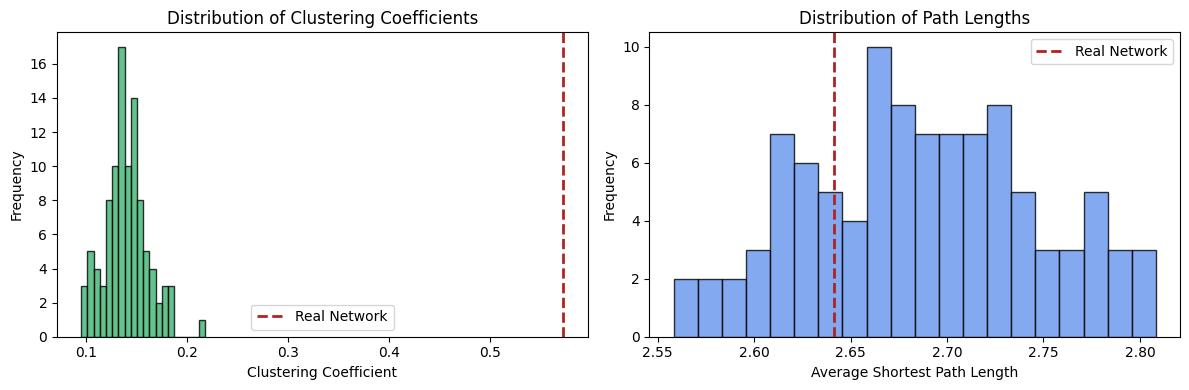

In [31]:
# Set up comparison of network properties
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of clustering coefficients
ax1.hist(clustering_values, bins=20, alpha=0.8, color='mediumseagreen', edgecolor='black')
ax1.axvline(x=real_clustering, color='firebrick', linestyle='--', linewidth=2, label='Real Network')
ax1.set_xlabel('Clustering Coefficient')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Clustering Coefficients')
ax1.legend()

# Histogram of path lengths
ax2.hist(path_length_values, bins=20, alpha=0.8, color='cornflowerblue', edgecolor='black')
ax2.axvline(x=real_path_length, color='firebrick', linestyle='--', linewidth=2, label='Real Network')
ax2.set_xlabel('Average Shortest Path Length')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Path Lengths')
ax2.legend()

plt.tight_layout()
plt.show()

### Statistical Tests

Now we'll perform statistical tests to determine if the real network's properties are significantly different from those of random networks with the same degree distribution.

In [29]:
def compute_stats(real_value, values, label):
    mean_val = np.mean(values)
    std_val = np.std(values)
    z_val = (real_value - mean_val) / std_val
    p_val = stats.norm.sf(abs(z_val)) * 2  # Two-tailed p-value
    signif = "Yes" if p_val < 0.05 else "No"
    return label, real_value, mean_val, std_val, z_val, p_val, signif

# Compute statistics for clustering and path length
results = [
    compute_stats(real_clustering, clustering_values, "Clustering Coefficient"),
    compute_stats(real_path_length, path_length_values, "Avg. Path Length")
]

# Define a fixed-width row format for alignment
row_format = "{:<25} {:>12} {:>12} {:>12} {:>10} {:>12} {:>12}"
print("Statistical Analysis Results:")
print(row_format.format("Property", "Real Value", "Random Mean", "Random Std", "Z-score", "p-value", "Significant?"))
print("-" * 97)
for label, real_val, mean_val, std_val, z_val, p_val, signif in results:
    print(row_format.format(label, f"{real_val:.4f}", f"{mean_val:.4f}", f"{std_val:.4f}", f"{z_val:.4f}", f"{p_val:.4e}", signif))


Statistical Analysis Results:
Property                    Real Value  Random Mean   Random Std    Z-score      p-value Significant?
-------------------------------------------------------------------------------------------------
Clustering Coefficient          0.5731       0.1395       0.0215    20.1749   1.6272e-90          Yes
Avg. Path Length                2.6411       2.6864       0.0593    -0.7622   4.4593e-01           No


## Conclusion and Key Takeaways

The configuration model has allowed us to test whether properties of the Les Misérables character network are simply a byproduct of its degree distribution or reflect additional organizational principles.

### Key findings:

1. **Degree preservation**: The configuration model successfully preserved the degree distribution of the original network.

2. **Clustering analysis**: We determined whether the clustering in the real network is significantly different from what would be expected by chance, which tells us about the tendency of characters to form cohesive groups.

3. **Path length analysis**: We assessed whether the efficiency of connections in the network (measured by path length) differs significantly from random expectations.

### Broader implications:

- **Network modeling**: When the real network's properties differ significantly from the configuration model, it suggests that specific organizing principles (beyond degree distribution) are at work.

- **Null model importance**: Statistical testing against appropriate null models is crucial for determining which network features are truly significant.

- **Network design**: Understanding which properties emerge naturally from degree distributions versus which require additional organization can inform the design of resilient or efficient networks.

This methodology can be applied to analyze any network structure, from social networks to biological systems to technological infrastructures.